# **Question Answering with the SQuAD Dataset**

This notebook demonstrates the implementation of an extractive question-answering Transformer network model using the [Stanford Question Answering Dataset (SQuAD)](https://huggingface.co/datasets/rajpurkar/squad). For this task, the [RoBERTa (Robustly Optimized BERT Pretraining Approach)](https://huggingface.co/docs/transformers/en/model_doc/roberta) model from [Hugging Face 🤗](https://huggingface.co/) is fine-tuned to improve its performance.

Hugging Face is a platform focused on developing tools and models for natural language processing (NLP). It is known for its open-source library called Transformers, which provides an easy-to-use interface for working with advanced pre-trained NLP models such as BERT, T5, GPT, and others.

**Key Points:**
- **Model Architecture:** The RoBERTa Large model from Hugging Face is used, which is based on [BERT](https://huggingface.co/docs/transformers/en/model_doc/bert) but achieves better results on GLUE, RACE, and SQuAD, datasets used to evaluate reasoning and text comprehension models. The model is loaded using the generic class [TFAutoModelForQuestionAnswering](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#transformers.TFAutoModelForQuestionAnswering), which allows creating an instance of a pre-trained model based on TensorFlow, specifically designed for question answering tasks, as it includes an appropriate classification layer on top. This differs from [TFAutoModel](https://huggingface.co/transformers/v3.0.2/model_doc/auto.html#tfautomodel), which provides the base model without additional layers.

- **Tokenization:** Hugging Face has implemented a tokenizer for each of its models that returns everything needed for the respective model's inputs. In this case, the generic tokenizer [AutoTokenizer](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoTokenizer) will be used, which allows creating an instance of the model's tokenizer by its name alone. For this Question Answering task, the question and context are passed to the tokenizer to return `input_ids` (the tokenized sequences) and `attention_mask` (a mask to avoid attending to padding token indices). Additionally, the tokenizer must return `offset_mapping`, which are the start and end positions of each token in the original text ('question' and 'context'), and `sequence_ids`, which are the ids of each part of the sequence; these are necessary to find the start and end tokens of the answers in `input_ids`. Lastly, only sequences with a length less than or equal to 512, which is the maximum length allowed by the RoBERTa tokenizer, are considered. In case sequences longer than this are introduced after training, the context is truncated and not the question, using the `only_second` argument.

- **Use of TPU:** Due to the enormous size of the RoBERTa model, specifically "roberta-large", which has over 300 million parameters, using the TPU in Google Colab is necessary to significantly accelerate training. Although only the parameters of the classification layer are adjusted, loading and processing pre-trained embeddings along with intensive backpropagation calculations require considerable computational resources. The TPU facilitates efficient handling of these tasks compared to GPUs or CPUs, optimizing performance and training time.

## **Imports**

In [ ]:
!pip install datasets -q

In [ ]:
import tensorflow as tf
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

from transformers import TFAutoModelForQuestionAnswering, AutoTokenizer
from datasets import load_dataset, load_from_disk, load_metric
from transformers import create_optimizer
import numpy as np
import plotly.graph_objects as go
from google.colab import drive
from IPython.core.display import HTML
from IPython.display import clear_output
import textwrap
from tqdm.auto import tqdm

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
epochs = 10
batch_size = 64
buffer_size = 1024
max_length = 512
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

model_name = "roberta-large"
train_filename = "/content/drive/MyDrive/Datasets/train_qa_roberta.tfrecord"
val_filename = "/content/drive/MyDrive/Datasets/val_qa_roberta.tfrecord"

## **Preprocessing and Saving Data in TFRecord Format**

Since SQuAD is large and the RoBERTa Large model is also substantial, the data is preprocessed, tokenized, and saved in TFRecord format, which allows for truly massive data pipeline performance for training on Colab's TPU. This is now more accessible as it is no longer necessary to store the TFRecord files in Google Cloud Storage due to the new version of Colab's TPU, ``TPU v2``, which has [transitioned from TPU Node to TPU VM](https://github.com/googlecolab/colabtools/issues/4481).

### **Load and Preprocess the Dataset**

In [ ]:
train_dataset, val_dataset = load_dataset("squad", split=["train", "validation"])

print(train_dataset)
val_dataset

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})


Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10570
})

In [ ]:
# See an example of the training dataset
train_dataset[0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

**Import the AutoTokenizer**

In [ ]:
# 'use_fast=True': improves the tokenizer's performance when processing large volumes of text

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

RobertaTokenizerFast(name_or_path='roberta-large', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [ ]:
# Example of tokenization

id = 1001
example = train_dataset[id]
print("Question:\n", example["question"], "\n")
print("Context:\n", textwrap.fill(example["context"], width=100), "\n")

encoding = tokenizer(
    example["question"],
    example["context"],
    padding="max_length",
    max_length=80,
    return_offsets_mapping=True
)

input_ids = encoding["input_ids"]
print("Input Ids:\n", input_ids, "\n")
print("Tokens:\n", tokenizer.convert_ids_to_tokens(input_ids), "\n")
print("Decoded Text without Special Tokens:\n", tokenizer.decode(input_ids, skip_special_tokens=True), "\n\n")

offsets = encoding["offset_mapping"]
print("Start and end position of each token in each original text ('question' and 'context'):\n", offsets, "\n")
sequence_ids = encoding.sequence_ids()
print("Sequence IDs:\n", sequence_ids, "\n\n")

start_char = example["answers"]["answer_start"][0]
end_char = start_char + len(example["answers"]["text"][0])
token_start_index, token_end_index = 0, len(input_ids) - 1

# Find the position of the first and last tokens corresponding to the answer, aligned with 'input_ids'
while sequence_ids[token_start_index] != 1:
  token_start_index += 1
while sequence_ids[token_end_index] != 1:
  token_end_index -= 1

while offsets[token_start_index][0] <= start_char:
  token_start_index += 1
token_start_index -= 1
while offsets[token_end_index][1] >= end_char:
  token_end_index -= 1
token_end_index += 1

print("Answer:\n", example["answers"]["text"][0], "\n")
print("Indices of the Start and End Tokens of the Answer:\n", token_start_index, token_end_index, "\n")
print("Tokenized Answer:\n", input_ids[token_start_index: token_end_index+1], "\n")
print("Decoded Answer:\n", tokenizer.decode(input_ids[token_start_index: token_end_index+1]), "\n\n")

print("Attention Mask:\n", encoding["attention_mask"])

Question:
 How has this foundation changed in recent years? 

Context:
 After Hurricane Katrina in 2005, Beyoncé and Rowland founded the Survivor Foundation to provide
transitional housing for victims in the Houston area, to which Beyoncé contributed an initial
$250,000. The foundation has since expanded to work with other charities in the city, and also
provided relief following Hurricane Ike three years later. 

Input Ids:
 [0, 6179, 34, 42, 4811, 1714, 11, 485, 107, 116, 2, 2, 4993, 4370, 16470, 11, 4013, 6, 12674, 12695, 8, 9224, 1245, 4790, 5, 30479, 2475, 7, 694, 23932, 2004, 13, 1680, 11, 5, 2499, 443, 6, 7, 61, 12674, 12695, 3162, 41, 2557, 68, 5714, 6, 151, 4, 20, 4811, 34, 187, 4939, 7, 173, 19, 97, 12237, 11, 5, 343, 6, 8, 67, 1286, 3500, 511, 4370, 16952, 130, 107, 423, 4, 2, 1, 1, 1, 1] 

Tokens:
 ['<s>', 'How', 'Ġhas', 'Ġthis', 'Ġfoundation', 'Ġchanged', 'Ġin', 'Ġrecent', 'Ġyears', '?', '</s>', '</s>', 'After', 'ĠHurricane', 'ĠKatrina', 'Ġin', 'Ġ2005', ',', 'ĠBeyon', 'cÃ©

**Filter the datasets to consider only sequences less than or equal to 512**

In [ ]:
def filter_datasets(example):
  encoding = tokenizer(example["question"], example["context"])
  return len(encoding["input_ids"]) <= max_length

train_dataset = train_dataset.filter(filter_datasets)
val_dataset = val_dataset.filter(filter_datasets)

len(train_dataset), len(val_dataset)

Filter:   0%|          | 0/87599 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


Filter:   0%|          | 0/10570 [00:00<?, ? examples/s]

(87456, 10521)

In [ ]:
print(87599 - len(train_dataset), 10570 - len(val_dataset))
143/87599, 49/10570

143 49


(0.0016324387264694802, 0.004635761589403974)

It is observed that the discarded sequences are not even 0.5% of the datasets.

**Tokenization**

In [ ]:
def preprocessing(examples):
  tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        padding="max_length",
        max_length=max_length,
        truncation="only_second",
        return_offsets_mapping=True
  )

  offset_mapping = tokenized_examples["offset_mapping"]
  tokenized_examples["start_position"] = []
  tokenized_examples["end_position"] = []

  for i, offsets in enumerate(offset_mapping):
    input_ids = tokenized_examples["input_ids"][i]
    sequence_ids = tokenized_examples.sequence_ids(i)
    answers = examples["answers"][i]

    start_char = answers["answer_start"][0]
    end_char = start_char + len(answers["text"][0])
    token_start_index, token_end_index = 0, len(input_ids) - 1

    while sequence_ids[token_start_index] != 1:
      token_start_index += 1
    while sequence_ids[token_end_index] != 1:
      token_end_index -= 1

    while (token_start_index < len(input_ids)) and (offsets[token_start_index][0]) <= start_char:
      token_start_index += 1
    while offsets[token_end_index][1] >= end_char:
      token_end_index -= 1

    tokenized_examples["start_position"].append(token_start_index - 1)
    tokenized_examples["end_position"].append(token_end_index + 1)

  return tokenized_examples

In [ ]:
train_dataset = train_dataset.map(preprocessing, batched=True, remove_columns=train_dataset.column_names)
val_dataset = val_dataset.map(preprocessing, batched=True, remove_columns=["title"])

Map:   0%|          | 0/87456 [00:00<?, ? examples/s]

Map:   0%|          | 0/10521 [00:00<?, ? examples/s]

In [ ]:
# Save the evaluation dataset for the Evaluation and Predictions section
val_dataset.save_to_disk("/content/drive/MyDrive/Datasets/val_dataset_squad_roberta")

Saving the dataset (0/1 shards):   0%|          | 0/10521 [00:00<?, ? examples/s]

### **Saving Data in TFRecord Format**

In [ ]:
def save_tfrecord(filename, dataset):
  with tf.io.TFRecordWriter(filename) as writer:
    for dic in tqdm(dataset):
      features = {
          "input_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=dic["input_ids"])),
          "attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(value=dic["attention_mask"])),
          "start_position": tf.train.Feature(int64_list=tf.train.Int64List(value=[dic["start_position"]])),
          "end_position": tf.train.Feature(int64_list=tf.train.Int64List(value=[dic["end_position"]]))
      }

      features = tf.train.Features(feature=features)
      example = tf.train.Example(features=features).SerializeToString()
      writer.write(example)

In [ ]:
save_tfrecord(train_filename, train_dataset)
save_tfrecord(val_filename, val_dataset)

  0%|          | 0/87456 [00:00<?, ?it/s]

  0%|          | 0/10521 [00:00<?, ?it/s]

## **Using the TPU for Training**

From this point onward until **Predictions with the Trained Model**, the use of TPU is mandatory, as each epoch takes approximately 16 minutes to complete even with its utilization.

In [ ]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except ValueError:
  print("TPU not found")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


### **Loading the Preprocessed Datasets**

In [ ]:
train_size, val_size = 87456, 10521

In [ ]:
def decode_tfrecord(sample):
  input_features = {
      "input_ids": tf.io.FixedLenFeature((max_length, ), tf.int64),
      "attention_mask": tf.io.FixedLenFeature((max_length, ), tf.int64)
  }

  output_features = {
      "start_position": tf.io.FixedLenFeature((), tf.int64),
      "end_position": tf.io.FixedLenFeature((), tf.int64),
  }

  input_parsed_features = tf.io.parse_example(sample, input_features)
  output_parsed_features = tf.io.parse_example(sample, output_features)
  return input_parsed_features, output_parsed_features


def load_dataset(filename, size, shuffle=True):
  dataset = tf.data.TFRecordDataset(filename)
  dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
  dataset = dataset.apply(tf.data.experimental.assert_cardinality(size))

  if shuffle:
    dataset = dataset.shuffle(buffer_size, seed=SEED)
  dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)

  return dataset

In [ ]:
train_dataset = load_dataset(train_filename, train_size)
val_dataset = load_dataset(val_filename, val_size, shuffle=False)

In [ ]:
# Viewing a training batch
for inputs, outputs in train_dataset.take(1):
  print(inputs["input_ids"], "\n")
  print(inputs["attention_mask"], "\n")
  print(outputs["start_position"], "\n")
  print(outputs["end_position"])

tf.Tensor(
[[    0   133   881 ...     1     1     1]
 [    0  1779   222 ...     1     1     1]
 [    0  2264    16 ...     1     1     1]
 ...
 [    0  1779    21 ...     1     1     1]
 [    0 13584 11330 ...     1     1     1]
 [    0 40401 25252 ...     1     1     1]], shape=(64, 512), dtype=int64) 

tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(64, 512), dtype=int64) 

tf.Tensor(
[ 50  22 128 111 154 150  54  98 104  14 137  80 200 144  35  25  25 173
 102 213  28  29  77  98  59  91  13 250  39  61 237 183  16 113 134  90
  61  50 108  71 212 131  16  75  55 176  22  47 138 158 165  36  18  95
  86  92 148  98  21 188 193  23 101  65], shape=(64,), dtype=int64) 

tf.Tensor(
[ 51  23 129 113 154 150  59  99 105  17 138  80 201 146  40  29  26 173
 104 214  29  31  77 105  62  96  26 253  40  64 237 183  18 115 136  91
  65  55 108  73 213 131  19  78  55 177  23  50 138 161 166  41  20  

### **Creation and Training of the Model**


Due to this model using two outputs representing the start and end positions of answer tokens, two identical losses of [``tf.keras.losses.SparseCategoricalCrossentropy``](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) are employed. Since the outputs from the base RoBERTa model have not yet undergone the ``argmax`` operation, it is necessary to set the ``from_logits=True`` argument. As an optimizer, [``tf.keras.optimizers.AdamW``](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/AdamW) is utilized, known for its computational efficiency, low memory requirements, invariance to diagonal gradient scaling changes, and suitability for large-scale data/parameter problems typical of Transformers models. It is employed with ``weight_decay=0.01`` to regularize the model weights and enhance generalization.

Although conventional ``accuracy`` is not ideal for evaluating this model, it serves as a useful approximation to monitor its performance. Therefore, two callbacks are used to monitor these metrics on the evaluation set to mitigate overfitting. Later, the model will be evaluated using official SQuAD metrics.

In [ ]:
callback_start = tf.keras.callbacks.EarlyStopping(
    monitor="val_start_position_accuracy",
    patience=2,
    mode="max",
    restore_best_weights=True
)

callback_end = tf.keras.callbacks.EarlyStopping(
    monitor="val_end_position_accuracy",
    patience=2,
    mode="max",
    restore_best_weights=True
)

In [ ]:
def create_model():
  # Import the AutoModel
  model_base = TFAutoModelForQuestionAnswering.from_pretrained(model_name)

  input_ids = tf.keras.Input((max_length, ), dtype=tf.int64, name="input_ids")
  attention_mask = tf.keras.Input((max_length, ), dtype=tf.int64, name="attention_mask")
  logits = model_base(input_ids=input_ids, attention_mask=attention_mask)

  # Activation layers do not alter the outputs; they only serve to rename them (linear: x=y)
  start_logits = tf.keras.layers.Activation("linear", name="start_position")(logits.start_logits)
  end_logits = tf.keras.layers.Activation("linear", name="end_position")(logits.end_logits)

  model = tf.keras.Model(
      inputs=[input_ids, attention_mask],
      outputs=[start_logits, end_logits]
  )

  return model

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

# Creation and compilation of the model within the distribution strategy
with strategy.scope():
  model = create_model()

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(
      optimizer=tf.keras.optimizers.AdamW(learning_rate=2e-5, weight_decay=0.01),
      loss={"start_position": loss_fn, "end_position": loss_fn},
      metrics={"start_position": "accuracy", "end_position": "accuracy"},
      steps_per_execution=200
  )

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForQuestionAnswering: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_for_question_an  TFQuestionAnsweringModelOu   3543121   ['input_ids[0][0]',           
 swering (TFRobertaForQuest  tput(loss=None, start_logi   94         'attention_mask[0][0]']      
 ionAnswering)               ts=(None, 512),                                                  

In [ ]:
tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[callback_start, callback_end])

Epoch 1/10
1367/1367 [==============================] - 1267s 927ms/step - loss: 1.8479 - start_position_loss: 0.9578 - end_position_loss: 0.8900 - start_position_accuracy: 0.7153 - end_position_accuracy: 0.7582 - val_loss: 1.6504 - val_start_position_loss: 0.8301 - val_end_position_loss: 0.8203 - val_start_position_accuracy: 0.7524 - val_end_position_accuracy: 0.7830
Epoch 2/10
1367/1367 [==============================] - 935s 684ms/step - loss: 1.3167 - start_position_loss: 0.6913 - end_position_loss: 0.6254 - start_position_accuracy: 0.7729 - end_position_accuracy: 0.8152 - val_loss: 1.6977 - val_start_position_loss: 0.8545 - val_end_position_loss: 0.8432 - val_start_position_accuracy: 0.7578 - val_end_position_accuracy: 0.7850
Epoch 3/10
1367/1367 [==============================] - 933s 682ms/step - loss: 1.0712 - start_position_loss: 0.5678 - end_position_loss: 0.5034 - start_position_accuracy: 0.8058 - end_position_accuracy: 0.8452 - val_loss: 1.8235 - val_start_position_loss: 0.

### **Save model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/ExtractiveQA_RoBERTa_SQuAD"

In [ ]:
model.layers[2].save_pretrained(trained_model_path)

## **Model Evaluation**

### **With conventional Accuracy**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(val_dataset, verbose=0))

[1.139520525932312, 0.5967417359352112, 0.5427783131599426, 0.8050104975700378, 0.8449048399925232]
[1.6977074146270752, 0.8544911742210388, 0.8432161211967468, 0.7578176856040955, 0.7850013971328735]


In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history["loss"])):
  losses = history[metric]
  val_losses = history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [ ]:
plot_metrics()
plot_metrics(metric="start_position_accuracy")
plot_metrics(metric="end_position_accuracy")

**Images for GitHub**

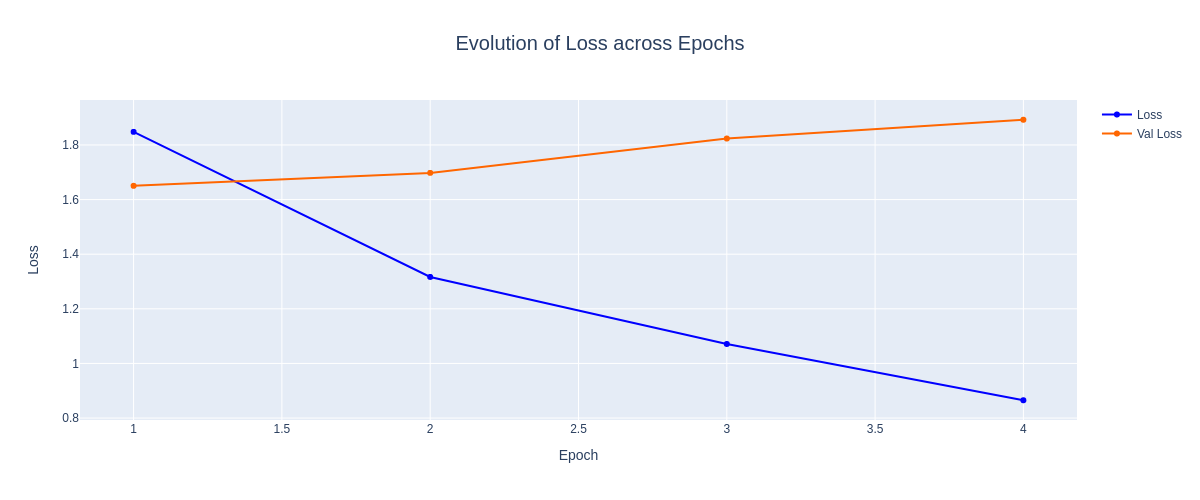

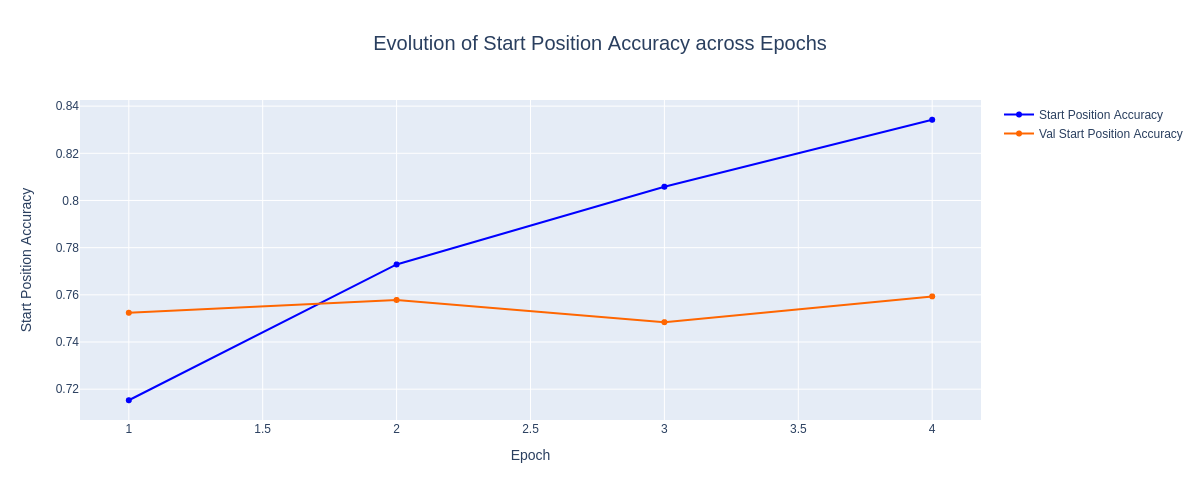

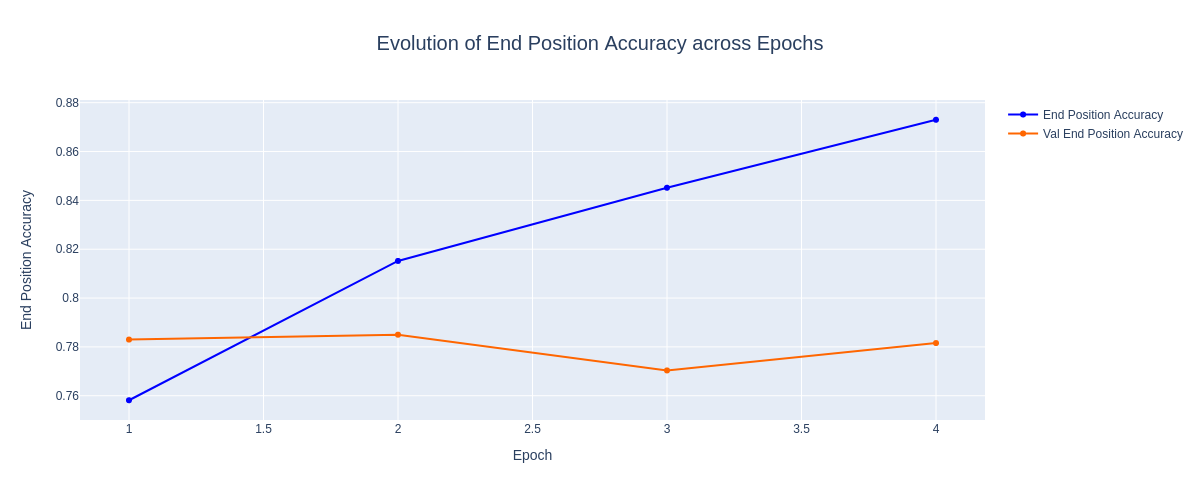

In [ ]:
plot_metrics(renderer="png")
plot_metrics(metric="start_position_accuracy", renderer="png")
plot_metrics(metric="end_position_accuracy", renderer="png")

### **With the official metrics for SQuAD**

In [ ]:
# Calculate the logits and load the saved evaluation dataset

logits = model.predict(val_dataset)
val_dataset_eval = load_from_disk("/content/drive/MyDrive/Datasets/val_dataset_squad_roberta")
n_best_size = 10

165/165 [==============================] - 106s 640ms/step


**Function to predict answers accurately for evaluation**

In [ ]:
def find_predictions(start_logits, end_logits, input_ids, offset, context, n_best_size):
  # Find the top n indices for start and end positions for the answers
  start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1]
  end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1]

  valid_indexes = []
  # Find all indices of separation tokens in 'input_ids'
  sep_indexes = [i for i, index in enumerate(input_ids) if index == tokenizer.sep_token_id]

  for start_index in start_indexes:
    for end_index in end_indexes:
      # Consider only valid answers that are found within the context
      condition = (start_index <= end_index) and (start_index > sep_indexes[1]) and (end_index < sep_indexes[2])

      if condition:
        start_char = offset[start_index][0]
        end_char = offset[end_index][1]

        valid_indexes.append({
            "score": start_logits[start_index] + end_logits[end_index],
            "predicted_answer": context[start_char: end_char],
            "start_position": start_char,
            "end_position": end_char
        })

  if len(valid_indexes) > 0:
    valid_indexes = sorted(valid_indexes, key=lambda x: x["score"], reverse=True)[:n_best_size]
  else:
    # Edge case where there are no valid answers within the top n logits
    valid_indexes = [{
        "score": 0.0,
        "predicted_answer": "",
        "start_position": 0,
        "end_position": 0
    }]

  return valid_indexes

In [ ]:
# Prediction example
id = 0
print("Prediction:")
preds = find_predictions(
    logits[0][id],
    logits[1][id],
    val_dataset_eval["input_ids"][id],
    val_dataset_eval["offset_mapping"][id],
    val_dataset_eval["context"][id],
    n_best_size=5
)
print(preds, "\n")
print("Context:\n", textwrap.fill(val_dataset_eval["context"][id], width=100), "\n")

print(f'Answer:\n{val_dataset_eval["answers"][id]["text"]}')

Prediction:
[{'score': 12.245036, 'predicted_answer': 'Denver Broncos', 'start_position': 177, 'end_position': 191}, {'score': 7.9997773, 'predicted_answer': 'Broncos', 'start_position': 184, 'end_position': 191}, {'score': 7.1816635, 'predicted_answer': 'Denver', 'start_position': 177, 'end_position': 183}, {'score': 6.884877, 'predicted_answer': 'The American Football Conference (AFC) champion Denver Broncos', 'start_position': 129, 'end_position': 191}, {'score': 6.3696775, 'predicted_answer': 'Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers', 'start_position': 177, 'end_position': 266}] 

Context:
 Super Bowl 50 was an American football game to determine the champion of the National Football
League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos
defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third
Super Bowl title. The game was played on February 7, 20

**Prepare the evaluation dataset to calculate the SQuAD metrics**

In [ ]:
def prepare_for_evaluation(logits, dataset, n_best_size=n_best_size):
  start_logits = logits[0]
  end_logits = logits[1]

  input_ids = dataset["input_ids"]
  offsets = dataset["offset_mapping"]
  contexts = dataset["context"]
  answers = dataset["answers"]
  ids = dataset["id"]

  predictions, references = [], []

  for i in tqdm(range(len(dataset))):
    prediction = find_predictions(
        start_logits[i],
        end_logits[i],
        input_ids[i],
        offsets[i],
        contexts[i],
        n_best_size=n_best_size
    )[0]

    predictions.append({
        "prediction_text": prediction["predicted_answer"],
        "id": ids[i]
    })

    references.append({
        "answers": answers[i],
        "id": ids[i]
    })

  return predictions, references

In [ ]:
predictions, references = prepare_for_evaluation(logits, val_dataset_eval)

  0%|          | 0/10521 [00:00<?, ?it/s]

In [ ]:
# Load the evaluation metric
metric = load_metric("squad")
metric

Metric(name: "squad", features: {'predictions': {'id': Value(dtype='string', id=None), 'prediction_text': Value(dtype='string', id=None)}, 'references': {'id': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}}, usage: """
Computes SQuAD scores (F1 and EM).
Args:
    predictions: List of question-answers dictionaries with the following key-values:
        - 'id': id of the question-answer pair as given in the references (see below)
        - 'prediction_text': the text of the answer
    references: List of question-answers dictionaries with the following key-values:
        - 'id': id of the question-answer pair (see above),
        - 'answers': a Dict in the SQuAD dataset format
            {
                'text': list of possible texts for the answer, as a list of strings
                'answer_start': list of start positions for the answer, as a list of ints
   

In [ ]:
metric.compute(predictions=predictions, references=references)

{'exact_match': 88.119000095048, 'f1': 94.07322256024572}

The conventional accuracy for the start and end positions of the answer tokens in the evaluation dataset is **75.78%** and **78.5%**, respectively. These figures are useful during training to assess the model's ability to identify the boundaries of the answers. However, the official SQuAD metrics, Exact Match and F1 Score, provide a more comprehensive and precise evaluation of the model's performance in the question-answering task.

The RoBERTa Large model has demonstrated exceptional performance in this task based on the SQuAD dataset. The high values obtained, with an **Exact Match** of **88.12%** and an **F1 Score** of **94.07%**, indicate that the model is capable of predicting answers with great accuracy and comprehensiveness. These results reflect the model's ability to generate responses that exactly match the correct answers and to capture the majority of the relevant information in its predictions.

## **Predictions with the Trained Model**

In [ ]:
# Load the trained model and the evaluation dataset
model = TFAutoModelForQuestionAnswering.from_pretrained(trained_model_path)
val_dataset= load_from_disk("/content/drive/MyDrive/Datasets/val_dataset_squad_roberta")

All model checkpoint layers were used when initializing TFRobertaForQuestionAnswering.

All the layers of TFRobertaForQuestionAnswering were initialized from the model checkpoint at /content/drive/MyDrive/models/ExtractiveQA_RoBERTa_SQuAD.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForQuestionAnswering for predictions without further training.


**Function to Predict Answers with HTML Format**

In [143]:
def predict_answer(contexts, questions=None, answers=None, n_best_size=n_best_size):
  if (questions is not None) and (answers is not None):
    indice = np.random.choice(len(contexts))
    context = contexts[indice]
    question = questions[indice]
    answer = answers[indice]

    tokenized_example = tokenizer(
        question,
        context,
        padding="max_length",
        max_length=max_length,
        truncation="only_second",
        return_offsets_mapping=True,
        return_tensors="tf"
    )

    logits = model(tokenized_example["input_ids"], tokenized_example["attention_mask"])
    prediction = find_predictions(
        logits.start_logits[0].numpy(),
        logits.end_logits[0].numpy(),
        tokenized_example["input_ids"][0].numpy(),
        tokenized_example["offset_mapping"][0].numpy(),
        context,
        n_best_size
    )[0]

    start_char = prediction["start_position"]
    end_char = prediction["end_position"]
    context = f"{context[:start_char]}<span style='background-color: yellow;'>{context[start_char:end_char]}</span>{context[end_char:]}"

    display(HTML(f"""
    <b>Context:</b><br>{context}<br><br>
    <b>Question: </b>{question}<br><br>
    <b>Predicted Answer: </b>{prediction['predicted_answer']}<br>
    <b>Score: </b>{prediction['score']}<br><br>
    <b>Answers: </b>{answer['text']}<br><br>
    """))

  else:
    c = 1
    display(HTML(f"<b>Context:</b><br>{contexts}<br><br>"))
    question = str(input())
    questions, predictions, scores = [question], [], []

    while question != "":
      tokenized_example = tokenizer(
          question,
          contexts,
          padding="max_length",
          max_length=max_length,
          truncation="only_second",
          return_offsets_mapping=True,
          return_tensors="tf"
      )

      logits = model(tokenized_example["input_ids"], tokenized_example["attention_mask"])
      prediction = find_predictions(
          logits.start_logits[0].numpy(),
          logits.end_logits[0].numpy(),
          tokenized_example["input_ids"][0].numpy(),
          tokenized_example["offset_mapping"][0].numpy(),
          contexts,
          n_best_size
      )[0]

      start_char = prediction["start_position"]
      end_char = prediction["end_position"]
      highlighted_context = f"{contexts[:start_char]}<span style='background-color: yellow;'>{contexts[start_char:end_char]}</span>{contexts[end_char:]}"
      predictions.append(prediction['predicted_answer'])
      scores.append(prediction['score'])
      c += 1

      clear_output(wait=True)
      html_content = f"<b>Context:</b><br>{highlighted_context}<br><br>"
      for i in range(len(questions)):
        html_content += f"""
        <b>Question {i+1}: </b>{questions[i]}<br>
        <b>Predicted Answer: </b>{predictions[i]}<br>
        <b>Score: </b>{scores[i]}<br><br>
        """

      display(HTML(html_content))
      question = str(input())
      questions.append(question)

### **Test Dataset**

In [144]:
contexts = val_dataset["context"]
questions = val_dataset["question"]
answers = val_dataset["answers"]

In [ ]:
predict_answer(contexts, questions, answers)

In [160]:
predict_answer(contexts, questions, answers)

In [ ]:
predict_answer(contexts, questions, answers)

In [149]:
predict_answer(contexts, questions, answers)

In [158]:
predict_answer(contexts, questions, answers)

### **Other Questions**

In [175]:
# The Matrix
context = "In a dystopian future, humanity is unknowingly trapped in a simulated reality called the Matrix, created by intelligent machines to subdue and control them. Neo, a computer programmer by day and hacker by night, discovers the truth and joins a group of rebels led by Morpheus. They believe Neo is the prophesied 'One' who can manipulate the Matrix and free humanity. As Neo trains and learns the true nature of reality, he must confront agents of the Matrix who seek to eliminate him and the rebel threat. The journey unfolds with mind-bending action and philosophical exploration as Neo navigates between the simulated world and the harsh reality of the war against the machines."
predict_answer(context)

In [193]:
# World War II
# The last question is not suited for an extractive question-answering task

context = "Second World War (1 September 1939 – 2 September 1945) was a global conflict between two alliances: the Allies and the Axis powers. Nearly all of the world's countries, including all of the great powers, participated in the conflict, and many invested all available economic, industrial, and scientific capabilities in pursuit of total war, blurring the distinction between civilian and military resources. Aircraft played a major role, enabling the strategic bombing of population centres and delivery of the only two nuclear weapons ever used in war. It was by far the deadliest conflict in history, resulting in 70–85 million fatalities. Millions died due to genocides, including the Holocaust, as well as starvation, massacres, and disease. In the wake of Axis defeat, Germany, Austria, Japan and Korea were occupied, and war crime tribunals were conducted against German and Japanese leaders. The causes of the war are debated; contributing factors included the rise of fascism in Europe, the Spanish Civil War, the Second Sino-Japanese War, Soviet–Japanese border conflicts, and tensions in the aftermath of World War I. World War II is generally considered to have begun on 1 September 1939, when Nazi Germany, under Adolf Hitler, invaded Poland. The United Kingdom and France declared war on Germany on 3 September. Under the Molotov–Ribbentrop Pact of August 1939, Germany and the Soviet Union had partitioned Poland and marked out their 'spheres of influence' across Finland, Estonia, Latvia, Lithuania, and Romania. From late 1939 to early 1941, in a series of campaigns and treaties, Germany conquered or controlled much of continental Europe in a military alliance called the Axis with Italy, Japan, and other countries. Following the onset of campaigns in North and East Africa, and the fall of France in mid-1940, the war continued primarily between the European Axis powers and the British Empire, with the war in the Balkans, the aerial Battle of Britain, the Blitz of the UK, and the Battle of the Atlantic. In June 1941, Germany led the European Axis powers in an invasion of the Soviet Union, opening the Eastern Front."
predict_answer(context)

**Conclusion:** The RoBERTa model fine-tuned for this question-answering task is excellent, achieving an **F1 score** of **94.07%** in the evaluation, a result that few models currently achieve with the SQuAD dataset. As seen in the predictions, the model finds appropriate answers even when the questions are a mix of literal and inferential. To further improve the model to answer inferential, critical, or generative level questions, it would be advisable to use an abstractive model, which generates free text directly based on the context. In this case, the model would adequately answer, for example, the last question about the context of World War II. However, for extractive questions, the model is more than sufficient.